✅ Saved raw PM10 TIFF as: ../geoserver_data/data\zurich_pm10_raw.tif
Min valid pixel value: 0.00
Max valid pixel value: 86.00
✅ Saved classified PM10 map as: ../geoserver_data/data\zurich_fuzzy_quality.tif


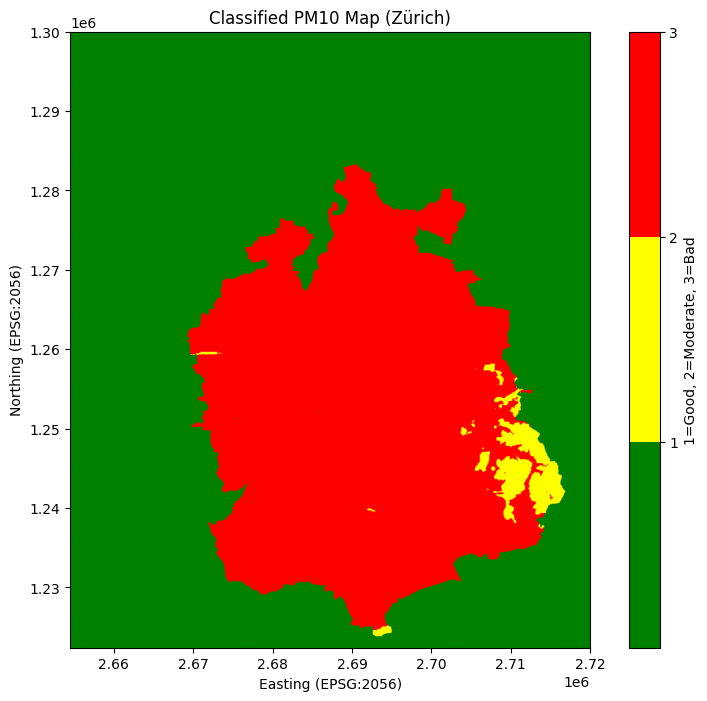

✅ Preview image saved as: ../geoserver_data/data\zurich_fuzzy_quality_preview.png


In [4]:
import rasterio
import numpy as np
import os
import requests
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# ------------------------------------------------------------
# Folders
data_in_geoserver_folder = "../geoserver_data/data"
os.makedirs(data_in_geoserver_folder, exist_ok=True)

# ------------------------------------------------------------
# PM10 layer info
year = 2023
pm10_wms_url = "https://wms.zh.ch/AwelLHPM10JahreZHWMS"
pm10_layer_name = f"pm10-jahre-{year}"

# Full Zurich extent in EPSG:2056 (from capabilities)
bbox = (2654500, 1222400, 2720000, 1300000)
width, height = 1600, 1200

# ------------------------------------------------------------
# Fetch PM10 map as TIFF
params = {
    "SERVICE": "WMS",
    "VERSION": "1.3.0",
    "REQUEST": "GetMap",
    "LAYERS": pm10_layer_name,
    "CRS": "EPSG:2056",
    "BBOX": f"{bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]}",
    "WIDTH": width,
    "HEIGHT": height,
    "FORMAT": "image/tiff"
}

r = requests.get(pm10_wms_url, params=params)
r.raise_for_status()

raw_tif_path = os.path.join(data_in_geoserver_folder, "zurich_pm10_raw.tif")
with open(raw_tif_path, "wb") as f:
    f.write(r.content)
print(f"✅ Saved raw PM10 TIFF as: {raw_tif_path}")

# ------------------------------------------------------------
# Read TIFF
with rasterio.open(raw_tif_path) as src:
    arr = src.read(1).astype(float)
    transform = src.transform
    crs = src.crs

# Mask out 255 (no-data) pixels
mask = arr != 255
valid_pixels = arr[mask]
max_pixel = valid_pixels.max()
min_pixel = valid_pixels.min()

print(f"Min valid pixel value: {min_pixel:.2f}")
print(f"Max valid pixel value: {max_pixel:.2f}")

# ------------------------------------------------------------
# Classification based on actual pixel range
classes = np.zeros_like(arr, dtype=np.uint8)

# Scale thresholds relative to the highest valid pixel
# 0–40% of max → good, 40–80% → moderate, 80–100% → bad
good_threshold = 0.4 * max_pixel
moderate_threshold = 0.8 * max_pixel

classes[(arr >= 0) & (arr < good_threshold) & mask] = 1
classes[(arr >= good_threshold) & (arr < moderate_threshold) & mask] = 2
classes[(arr >= moderate_threshold) & mask] = 3

# ------------------------------------------------------------
# Save classified TIFF
classified_path = os.path.join(data_in_geoserver_folder, "zurich_fuzzy_quality.tif")
with rasterio.open(
    classified_path,
    "w",
    driver="GTiff",
    height=classes.shape[0],
    width=classes.shape[1],
    count=1,
    dtype=classes.dtype,
    crs=crs,
    transform=transform
) as dst:
    dst.write(classes, 1)
print(f"✅ Saved classified PM10 map as: {classified_path}")

# ------------------------------------------------------------
# Preview the classified map
cmap = ListedColormap(["green", "yellow", "red"])
plt.figure(figsize=(10, 8))
plt.imshow(classes, cmap=cmap, extent=[bbox[0], bbox[2], bbox[1], bbox[3]])
plt.title("Classified PM10 Map (Zürich)")
plt.xlabel("Easting (EPSG:2056)")
plt.ylabel("Northing (EPSG:2056)")
plt.colorbar(ticks=[1, 2, 3], label="1=Good, 2=Moderate, 3=Bad")
preview_path = os.path.join(data_in_geoserver_folder, "zurich_fuzzy_quality_preview.png")
plt.savefig(preview_path, dpi=200, bbox_inches='tight')
plt.show()
print(f"✅ Preview image saved as: {preview_path}")
